# Проект      
Представлена информация по трем интернет-магазинам:    мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков.   
В них есть обезличенная история покупок клиентов за определенный период
Цель:   
Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней   
Исходные данные   
файлы   
marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;   
apparel - магазин одежды, по характеристикам похожий на маркетплейс;   
gifts – магазин подарков, очень маленький;   
колонки      
client_id – идентификатор клиента;   
quantity – количество товара в заказе;   
price – цена 1 единицы товара в заказе;   
message_id – идентификатор сообщения из рассылки   
date – дата покупки;   

##План работы   
--изучить предоставленные данные   
--создать полезные признаки для обучения модели   
--создать целевой признак   
--предложить и обосновать метрику   
--обучить и протестировть модели   




###1.   изучить предоставленные данные




In [145]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [146]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [147]:
!pip install catboost

In [148]:
from catboost import CatBoostRegressor

In [149]:
market_plc = pd.read_csv('/content/marketplace-purchases.csv')
market_app = pd.read_csv('/content/apparel-purchases.csv')
market_gft = pd.read_csv('/content/gifts-purchases.csv')

посмотрим информацию о датасетах

In [150]:
name = "market_plc","market_app","market_gft"
list = market_plc,market_app, market_gft
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    display(list[i].head(4))
    list[i].info()
    list[i].isna().sum()

 
market_plc


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB
 
market_app


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB
 
market_gft


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


смотрим наличие пропусков-они отсутствуют


In [151]:
name = "market_plc","market_app","market_gft"
list = market_plc,market_app, market_gft
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    print(list[i].isna().sum())

 
market_plc
client_id     0
quantity      0
price         0
message_id    0
created_at    0
date          0
dtype: int64
 
market_app
client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64
 
market_gft
client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64


смотрим наличие дубликатов и количество- присуствуют

In [152]:
name = "market_plc","market_app","market_gft"
list = market_plc,market_app, market_gft
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    print(list[i].duplicated().sum())

 
market_plc
2159
 
market_app
59250
 
market_gft
56


посмотрим на сами дубликаты, увидим, что они могут совпадать поностью не только по датам, но и в случае market_plc даже до секунды. в связи с тем, что нам известно , что перед нами история покупок, то будем считать одну строку  как одну покупку,то есть  по сути это не дубликаты, а разные покупки просто обозначены одинаково, т.к. у  нас нет данных, которые могут точно указывать на то что это дубликаты (к примеру артикул товара)

In [153]:
name = "market_plc","market_app","market_gft"
list = market_plc,market_app, market_gft
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    display(list[i].loc[list[i].duplicated(keep=False)].head(10))

 
market_plc


,client_id,quantity,price,message_id,created_at,date
76,1515915625448676587,1,398.0,1515915625448676587-1802-64634e24b3fc8,2023-05-17,2023-05-17 09:37:33
77,1515915625448676587,1,398.0,1515915625448676587-1802-64634e24b3fc8,2023-05-17,2023-05-17 09:37:33
330,1515915625498312385,1,2.0,1515915625498312385-1762-64537436851e4,2023-05-04,2023-05-04 11:28:57
332,1515915625498312385,1,2.0,1515915625498312385-1762-64537436851e4,2023-05-04,2023-05-04 11:28:57
411,1515915625511917432,1,2.0,1515915625511917432-1755-6452270bbea9c,2023-05-05,2023-05-05 19:59:48
413,1515915625511917432,1,2.0,1515915625511917432-1755-6452270bbea9c,2023-05-05,2023-05-05 19:59:48
420,1515915625512215179,1,2.0,1515915625512215179-1744-644a3040ca0e2,2023-05-01,2023-05-01 07:27:13
421,1515915625512215179,1,2.0,1515915625512215179-1744-644a3040ca0e2,2023-05-01,2023-05-01 07:27:13
423,1515915625512215179,1,2.0,1515915625512215179-1744-644a3040ca0e2,2023-05-01,2023-05-01 07:27:13
458,1515915625441367363,1,2.0,1515915625441367363-1589-63ff2857c7d65,2023-03-02,2023-03-02 09:25:25


 
market_app


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
5,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
8,1515915625468079941,1,1499.0,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message
9,1515915625468079941,1,1068.0,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message
10,1515915625468079941,1,1499.0,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message
11,1515915625468079941,1,1068.0,2023-09-01,1515915625468079941-13718-64e899a67a51d,bulk_message


 
market_gft


,client_id,quantity,price,date,message_id,recommended_by
13,1515915625803894158,1,14802.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
14,1515915625803894158,1,14802.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
15,1515915625803894158,1,6778.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
16,1515915625803894158,1,6778.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
19,1515915625803894158,1,5790.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
20,1515915625803894158,1,5790.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
127,1515915625942320604,1,3278.0,2023-07-14,1515915625942320604-14067-64aeacd7ce919,bulk_message
129,1515915625942320604,1,3278.0,2023-07-14,1515915625942320604-14067-64aeacd7ce919,bulk_message
223,1515915625803892965,1,25990.0,2023-03-21,1515915625864123161-11100-64185f9ab960b,bulk_message
224,1515915625803892965,1,25990.0,2023-03-21,1515915625864123161-11100-64185f9ab960b,bulk_message


смотрим совпадают ли ID клиентов в разных магазинах - совпадений нет, возможно это связано с разной нумерацией  клиентов,вероятно они не отмечают у себя одних и тех же клиентов одинаково, в любом случае, в разных магазинах нет дублей ID

In [154]:
print(market_plc['client_id'].isin(market_gft['client_id']).value_counts ())
print(market_app['client_id'].isin(market_plc['client_id']).value_counts ())
print(market_gft['client_id'].isin(market_app['client_id']).value_counts ())

False    48182
Name: client_id, dtype: int64
False    133104
Name: client_id, dtype: int64
False    811
Name: client_id, dtype: int64


смотрим, когда одна сумма и один клиент одинаковое количество товара в одну дату - будем иметь в виду,   когда преобразуем столбец просто в дату без указания времени,что это не дубликаты, а  отдельная покупка в одну дату, но в разное время

In [155]:
mask = (market_plc.duplicated(subset=['client_id', 'created_at','price'], keep=False)) & (~market_plc.duplicated(subset=['date', 'client_id', 'created_at','price'], keep=False))
result = market_plc[mask]
result

,client_id,quantity,price,message_id,created_at,date
23,1515915625442077093,1,34998.0,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 19:52:38
24,1515915625442077093,1,34998.0,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 20:00:04
26,1515915625442077093,1,34998.0,1515915625442077093-1787-645cb877381e0,2023-05-15,2023-05-15 20:18:25
36,1515915625443176973,1,37998.0,1515915625443176973-1794-6461ff30d1d36,2023-05-16,2023-05-16 07:38:36
37,1515915625443176973,1,37998.0,1515915625443176973-1794-6461ff30d1d36,2023-05-16,2023-05-16 07:39:39
...,...,...,...,...,...,...
48156,1515915625575544090,1,20998.0,1515915625525944269-1738-64479d7e1da12,2023-04-25,2023-04-25 14:14:54
48159,1515915625575644960,1,57998.0,1515915625534596840-1743-6449f5fcb1a32,2023-04-27,2023-04-27 04:27:06
48160,1515915625575644960,1,57998.0,1515915625534596840-1743-6449f5fcb1a32,2023-04-27,2023-04-27 04:28:33
48180,1515915625575809442,1,15998.0,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:48:11


посмотрим совпадают ли даты в столбцах created_at и date при совпадении столбец date можно удалить, а created_at переименовать в date

In [156]:
market_plc['date_m_y_d'] = market_plc['date'].str.split().str[0]
are_equal = market_plc['date_m_y_d'].equals(market_plc['created_at'])

if are_equal:
    print("Столбцы created_at и date идентичны по дате.")
else:
    print("Столбцы created_at и date имеют различия.")


Столбцы created_at и date идентичны по дате.


In [157]:
market_plc.drop(['date_m_y_d'], axis=1, inplace=True)

посмотрим содержимое столбца recommended_by, он встречается в двух таблицах и содержит одно значение, его можно будет удалить при подготовке фичей, также можно удалить и message_id,т.к. эти столбцы  не содержат значимую информацию для нашего проекта

In [158]:
a=market_app['recommended_by'].unique()
a=pd.DataFrame(a)
a.sort_values(0)

,0
0,bulk_message


In [159]:
b=market_gft['recommended_by'].unique()
b=pd.DataFrame(b)
b.sort_values(0)

,0
0,bulk_message


посмотрим диапазон дат - с 2022-10-26 по 2023-10-26 - получается ровно за год, только в магазине подарков 2 дня не достает

In [160]:
name = "market_plc","market_app","market_gft"
list = market_plc['date'],market_app['date'], market_gft['date']
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    print(list[i].min())
    print(list[i].max())

 
market_plc
2022-10-26 08:35:46
2023-10-26 13:34:11
 
market_app
2022-10-26
2023-10-26
 
market_gft
2022-10-26
2023-10-24


посмотрим количество клиентов в каждом магазине

In [161]:
print("market_plc")
print(market_plc['client_id'].nunique())
print("market_app")
print(market_app['client_id'].nunique())
print("market_gft")
market_gft['client_id'].nunique()

market_plc
17787
market_app
28891
market_gft


326

посмотрим количество клиентов по месяцам в магазине маркетплейс - в ноябре растут, самое большое кол-во в сентябре, февраль на втором месте

In [162]:
market_plc['date_m_y'] = market_plc['created_at'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
monthly_counts_plc = market_plc['date_m_y'].value_counts()
monthly_counts_plc = monthly_counts_plc.sort_index()

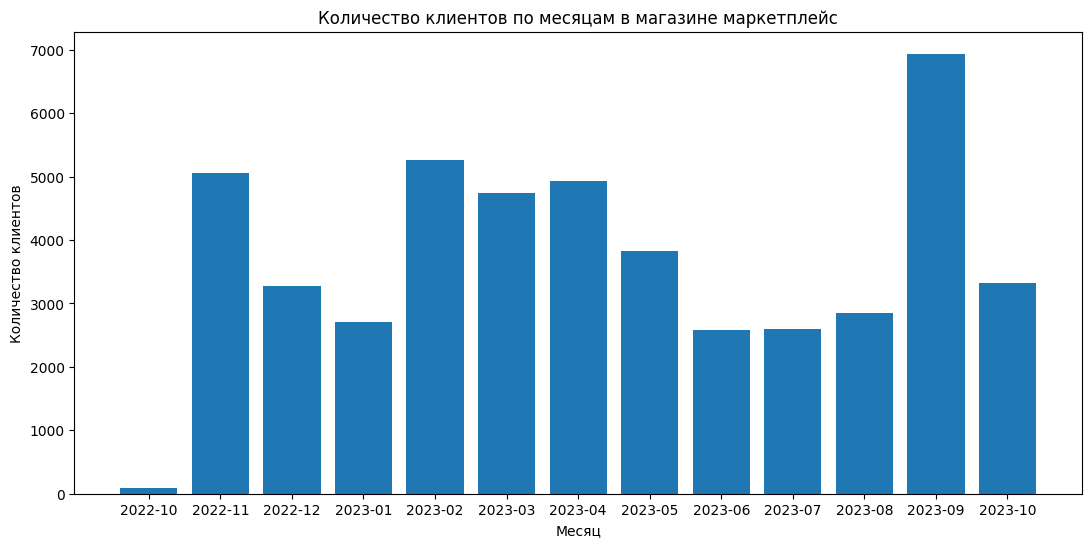

In [163]:
plt.figure(figsize=(13, 6))
plt.bar(monthly_counts_plc.index, monthly_counts_plc)
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов по месяцам в магазине маркетплейс')
plt.show()

посмотрим продажи  по месяцам в магазине маркетплейс - в ноябре растут, самое большое кол-во в  феврале, на втором месте март, в сентябре тоже прирост

In [164]:
monthly_sum_plc = market_plc.groupby('date_m_y')['price'].sum()
monthly_sum_plc = monthly_sum_plc.sort_index()

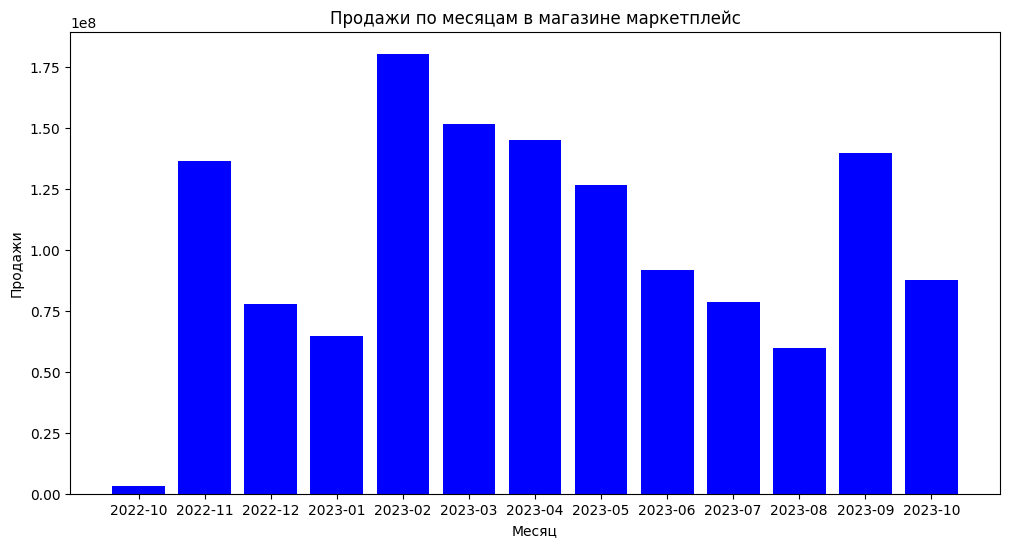

In [165]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_sum_plc.index, monthly_sum_plc,color='blue')
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.title('Продажи по месяцам в магазине маркетплейс')
plt.show()

In [166]:
market_plc.drop(['date_m_y'], axis=1, inplace=True)

посмотрим количество клиентов по месяцам в магазине аппарель - в ноябре вырастают, самое большое количество в июне

In [167]:
market_app['date_m_y'] = market_app['date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
monthly_counts_app = market_app['date_m_y'].value_counts()
monthly_counts_app = monthly_counts_app.sort_index()

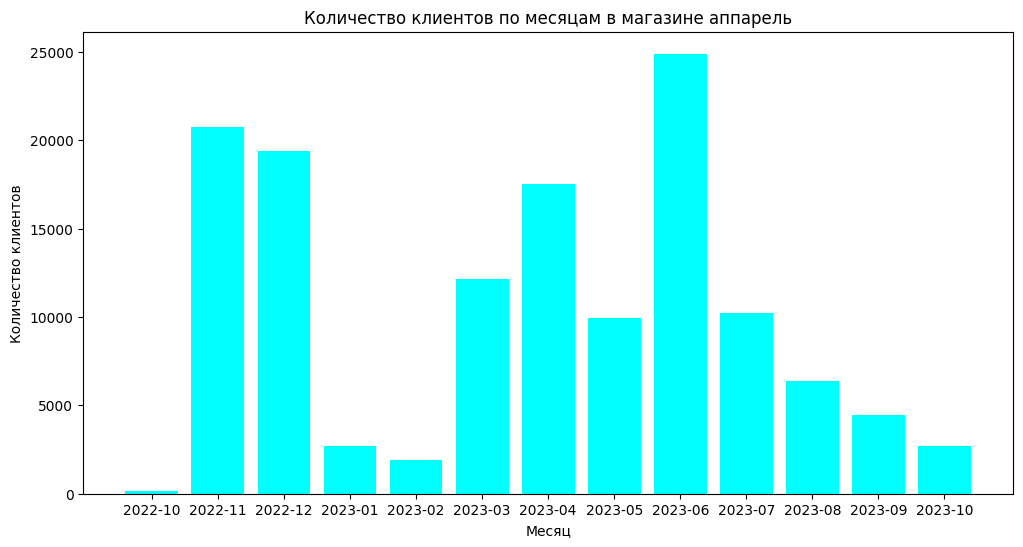

In [168]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_app.index, monthly_counts_app,color='Cyan')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов по месяцам в магазине аппарель')
plt.show()

посмотрим продажи по месяцам в магазине аппарель - в ноябре 2022 года самые большие продажи,а в 2023 самое большое количество в июне

In [169]:
monthly_sum_app = market_app.groupby('date_m_y')['price'].sum()
monthly_sum_app = monthly_sum_app.sort_index()

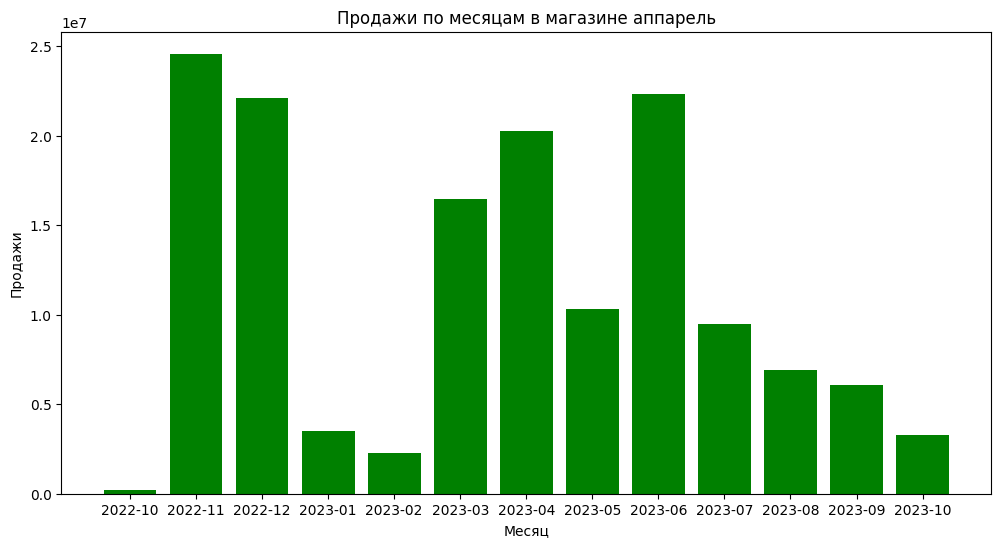

In [170]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_sum_app.index, monthly_sum_app, color='green')
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.title('Продажи по месяцам в магазине аппарель')
plt.show()

In [171]:
market_app.drop(['date_m_y'], axis=1, inplace=True)

посмотрим количество клиентов по месяцам в магазине подарков - данные за прошлый год показывают, что в ноябре количество клиентов вырастает, можно учесть это, также высокое количество в июле

In [172]:
market_gft['date_m_y'] = market_gft['date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
monthly_counts_gft = market_gft['date_m_y'].value_counts()
monthly_counts_gft = monthly_counts_gft.sort_index()

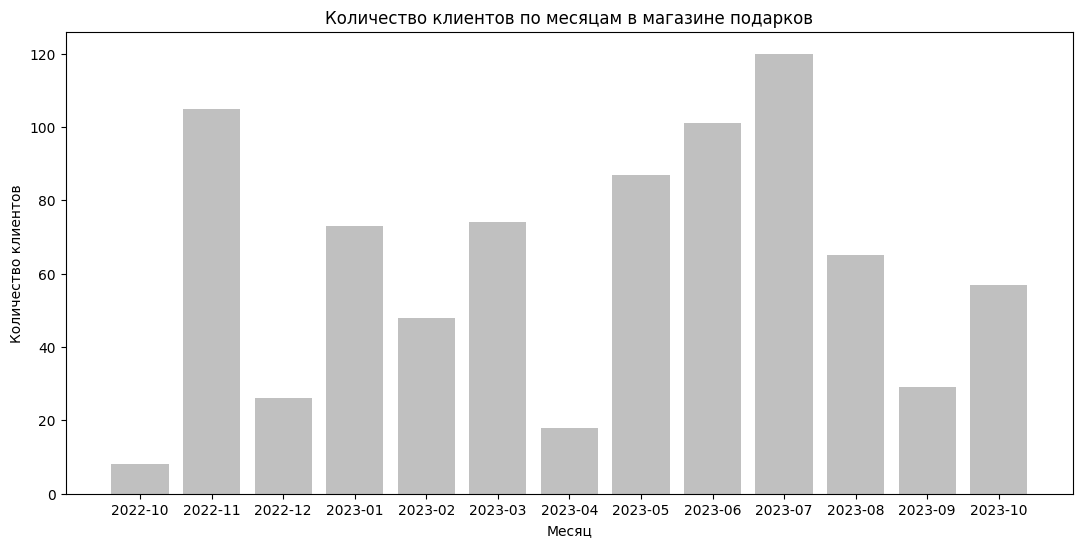

In [173]:
plt.figure(figsize=(13, 6))
plt.bar(monthly_counts_gft.index, monthly_counts_gft,color='Silver')
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов по месяцам в магазине подарков')
plt.show()

посмотрим продажи по месяцам магазине подарков - коррелирует с количеством клиентов - увеличивается в ноябре, и высокое в июле

In [174]:
market_gft['date_m_y'] = market_gft['date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
monthly_sum_gft = market_gft.groupby('date_m_y')['price'].sum()
monthly_sum_gft = monthly_sum_gft.sort_index()

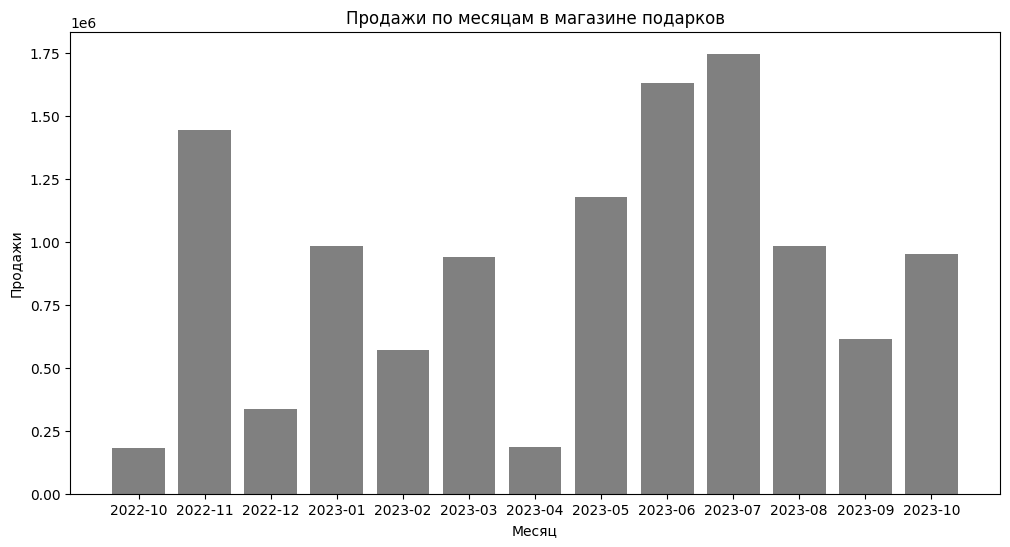

In [175]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_sum_gft.index, monthly_sum_gft,color='Gray')
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.title('Продажи по месяцам в магазине подарков')
plt.show()

In [176]:
market_gft.drop(['date_m_y'], axis=1, inplace=True)

Выводы по данным:   
Данные у нас представлены 3 отдельными таблицами - это информация о истории покупок из 3 магазинов. Назовем их:
маркетплейс, аппарель и подарки, -соответсвенно названы датасеты для анализа.   
Столбцы сообщают информацию о
присвоенном номере клиента client_id количестве товара в одном заказе quantity,
сумме заказа price и дате date. Присутствует еще столбец message_id и recommended_by( о них еще напишем ниже),
но в этом проекте их не рассматриваем, так что при подготовке признаков они будут удалены.   
Строки - это записи об отдельных покупках.
В маркетплейсе их 48182 строки , аппареле 133104, подарки -811. Проверили наличие пропусков, они отсуствуют.
Учтем, что есть в market_plc покупки , которые отличаются только по времени в одну дату, а сумма и количество одинаковые.
Кроме этого строки могут совпадать полностью  по датам не только до дня,
но и в случае market_plc даже до секунды. В связи с тем, что нам известно , что перед нами история покупок, то будем считать одну строку как одну покупку,то есть по сути это не дубликаты, а разные покупки просто обозначены одинаково, т.к. у нас нет данных, которые могут точно указывать на то что это дубликаты (к примеру артикул товара).
Посмотрели совпадают ли ID клиентов в разных магазинах - совпадений нет, возможно это связано с разной нумерацией
клиентов,вероятно они не отмечают у себя одних и тех же клиентов одинаково, в любом случае, в разных магазинах нет дублей ID.
Убедились,что даты в столбцах created_at и date совпадают, соответсвенно столбец date можно удалить, а created_at переименовать в date
Проверили содержимое столбца recommended_by, он встречается в двух таблицах и содержит одно значение, его можно будет удалить при подготовке фичей,
также можно удалить и message_id,т.к. эти столбцы  не содержат значимую информацию для нашего проекта.   
Диапазон дат представленных в датасетах - с 2022-10-26 по 2023-10-26 - получается ровно за год, только в магазине подарков 2 дня не достает.
Количество клиентов в маркетплейсе 17787 , в аппареле 28891, подарки -326.   

Анализ количества клиентов и продаж в магазинах по месяцам:         
Мы посмотрели распределение количества клиентов по месяцам
в магазине маркетплейс - в ноябре 2022 года они значительно приросли по сравнени с октябрем, самое большое кол-во в сентябре, февраль на втором месте.
Посмотрим продажи по месяцам в магазине маркетплейс - в ноябре 2022 года также прирост, самое большое кол-во в феврале, на втором месте март, в сентябре тоже прирост
Получается прирост клиентов не всегда дает сопоставимый прирост продаж, кроме в ноября прошлого года. Вероятно в этом году в ноябре прирост клиенто обеспечит
сопоставимый прирост продаж. Количество клиентов по месяцам в магазине аппарель - в ноябре вырастают, самое большое количество в июне
 Продажи по месяцам в магазине аппарель - в ноябре 2022 года самые большие продажи,а в 2023 самое большое количество в июне.
Посмотрим количество клиентов по месяцам в магазине подарков - данные за прошлый год показывают, что в ноябре количество клиентов вырастает,
 можно учесть это, также высокое количество в июле 2023, продажи в этом магазине также прирастают в эти месяцы.
Из графиков очевидно, что есть месяцы особого прироста клиентов и продаж.
Во всех трех магазинах наблюдался прирост клиентов и продаж в ноябре 2022 года, разумно ожидать подобный прирост в ноябре 2023, т.е
как раз в наш целевой диапазон. Если бы  данных было предоставлено за большее время(два три года), то
 для дальнейшего создания признаков можно было бы учесть, что вероятно есть клиенты, которые приходят в высокий сезон продаж, что ожидается
в ноябре, соответсвенно нужно будет выделить группу, которая появляется только в пиковые месяцы.
Кроме этого стоит отметить ,что в магазине подарков вероятно есть группа,которая может появиться только в ноябре
для приобретения подарков по личному поводу раз в год.    

Если бы  данных было предоставлено за большее время(два три года), то
 для дальнейшего создания признаков можно было бы учесть вышепирведенный помесячный анализ, однако уже сейчас можно учитывать эту аналитику и представить ее для использования заказчику. Возможно данные будут дополнены.

###2.   создать полезные признаки для обучения модели

удалим столбцы, которые нам не понядобятся в этом проекте recommended_by и message_id, они присутствуют в двух таблицах

In [177]:
name = "market_app","market_gft"
list = market_app, market_gft
for i, element in enumerate(name):
    print(" ")
    print(name[i])
    list[i].drop(['message_id','recommended_by'], axis=1, inplace=True)
    display(list[i].head(4))


 
market_app


,client_id,quantity,price,date
0,1515915625468068833,1,3499.0,2023-09-08
1,1515915625468068833,1,3499.0,2023-09-08
2,1515915625468068833,1,3499.0,2023-09-08
3,1515915625468068833,1,2450.0,2023-09-08


 
market_gft


,client_id,quantity,price,date
0,1515915625803894158,1,8943.0,2023-10-11
1,1515915625803894158,1,46369.0,2023-10-11
2,1515915625803894158,1,4666.0,2023-10-11
3,1515915625803894158,1,11963.0,2023-10-11


столбец date  удалим, а created_at переименуем в date для единообразия всех таблиц


In [178]:
market_plc.drop(['date','message_id'], axis=1, inplace=True)
market_plc.rename({'created_at': 'date'}, axis=1, inplace=True)
market_plc.head(4)

,client_id,quantity,price,date
0,1515915625440944408,1,6298.0,2023-05-02
1,1515915625440992498,1,7318.0,2023-05-22
2,1515915625441026424,1,65798.0,2023-05-17
3,1515915625441118180,1,5598.0,2023-05-23


добавим ко всем таблицам столбец с меткой  магазина numbmarket маркетлпейc будет 111, аппарель 222, магазин подарков 333, объедими таблицы в один датасет

In [179]:
market_plc['numbmarket'] = 111
market_app['numbmarket'] = 222
market_gft['numbmarket'] = 333

In [180]:
market = pd.concat([market_plc, market_app,market_gft])
market

,client_id,quantity,price,date,numbmarket
0,1515915625440944408,1,6298.0,2023-05-02,111
1,1515915625440992498,1,7318.0,2023-05-22,111
2,1515915625441026424,1,65798.0,2023-05-17,111
3,1515915625441118180,1,5598.0,2023-05-23,111
4,1515915625441124500,1,77998.0,2023-05-25,111
...,...,...,...,...,...
806,1515915625870025628,1,39992.0,2022-11-28,333
807,1515915625873498326,1,3035.0,2022-11-23,333
808,1515915625873498326,1,3035.0,2022-11-23,333
809,1515915625878133961,1,3442.0,2022-11-26,333


перемешаем строки в случайном порядке, предварительно закрепив получаемый результат

In [181]:
np.random.seed(0)


In [182]:
market = market.iloc[np.random.permutation(len(market))]

In [183]:
market = market.reset_index(drop=True)
market

,client_id,quantity,price,date,numbmarket
0,1515915625468190149,1,1657.0,2023-03-18,222
1,1515915625500590075,1,69.0,2022-12-22,222
2,1515915625499023521,1,7522.0,2023-02-10,111
3,1515915625584188537,1,19998.0,2023-09-07,111
4,1515915625559887128,1,66.0,2023-05-11,222
...,...,...,...,...,...
182092,1515915625817333299,1,999.0,2023-06-22,222
182093,1515915625858844689,1,7.0,2023-04-11,222
182094,1515915625557925346,1,199.0,2023-03-29,222
182095,1515915625757652006,1,1539.0,2023-04-14,222


In [184]:
market['date'] = pd.to_datetime(market['date'])

In [185]:
market['totalpr'] = market['quantity'] * market['price']
market['trans_ym'] = market['date'].apply(lambda x: x.strftime('%Y%m'))
market['lastbaydate'] = market.groupby('client_id')['date'].transform('max')
market['dayssincebay'] = (market['lastbaydate'].max() - market['lastbaydate']).dt.days
market['nextbaydate'] = market.groupby('client_id')['date'].transform(lambda x: x.max() + timedelta(days=np.random.randint(1, 30)))


###3.   создать целевой признак

daystobay обозначим столбец с днем следующей покупки, мы будем предсказывать сколько дней осталось, в дальнейшем сможем отобрать тех, кто будет покупателем в целевые ближайшие 30 дней

In [186]:
market['daystobay'] = (market['nextbaydate'] - market['date']).dt.days
market['numbmarket'] = market['numbmarket']
market = market[['client_id', 'numbmarket','totalpr', 'trans_ym', 'dayssincebay', 'daystobay']]
market = market.drop_duplicates()

In [187]:
market

,client_id,numbmarket,totalpr,trans_ym,dayssincebay,daystobay
0,1515915625468190149,222,1657.0,202303,222,12
1,1515915625500590075,222,69.0,202212,308,25
2,1515915625499023521,111,7522.0,202302,258,24
3,1515915625584188537,111,19998.0,202309,42,21
4,1515915625559887128,222,66.0,202305,168,18
...,...,...,...,...,...,...
182080,1515915625912328708,222,204.0,202306,112,35
182082,1515915625491873409,222,237.0,202304,191,12
182085,1515915625471162973,222,499.0,202309,55,3
182086,1515915625496653544,222,2999.0,202302,267,12


###4. обоснование метрики

для оценки модели будем использовать универсальную для регрессии метрику mae она покажет на склько в среднем мы отклонились от точного предсказания ,а также mse, она покажет насколько разные модели меньше допускают больших ошибок

###5.   обучение и тестирование моделей

проведем разбивку датасета на трейн и тест

In [188]:
RANDOM=51

In [189]:
X = market.drop(['daystobay'], axis=1)
y = market['daystobay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM)

посмотрим в работе RandomForestRegressor  


In [190]:
%%time
model = RandomForestRegressor( random_state=RANDOM)
model.fit(X_train, y_train)

CPU times: user 22.3 s, sys: 331 ms, total: 22.6 s
Wall time: 22.7 s


RandomForestRegressor(random_state=51)

посмотрим, какое значение метрик покажет модель RandomForestRegressor

In [191]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

Mean Absolute Error: 7.641831559997675
Mean Squared Error: 89.44837926920485


посмотрим в работе CatBoostRegressor

In [192]:
%%time
model_c = CatBoostRegressor( random_state=RANDOM)
model_c.fit(X_train,y_train,verbose=False)

CPU times: user 21.6 s, sys: 639 ms, total: 22.2 s
Wall time: 12.6 s


In [193]:
y_pred_c = model_c.predict(X_test)

посмотрим, какое значение метрик покажет модель CatBoostRegressor

In [194]:
mae = mean_absolute_error(y_test, y_pred_c)
mse = mean_squared_error(y_test, y_pred_c)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

Mean Absolute Error: 7.541354402396227
Mean Squared Error: 79.53559678727963


проведем перебор параметров модели CatBoostRegressor

In [195]:
%%time
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 200],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostRegressor(random_state=RANDOM, verbose=0)

ct_modgr = GridSearchCV(model, param_grid, cv=5, scoring=mean_absolute_error)
ct_modgr.fit(X_train,y_train)

print(ct_modgr.best_params_)
print(ct_modgr.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: mean_absolute_error() takes 2 positional arguments but 3 were given

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


{'iterations': 50, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
nan
CPU times: user 1min 33s, sys: 2.98 s, total: 1min 36s
Wall time: 56.2 s


In [196]:
y_pred_cc = ct_modgr.predict(X_test)

смотрим метрику модщели подбора параметров CatBoostRegressor

In [197]:
mae = mean_absolute_error(y_test, y_pred_cc)
mse = mean_squared_error(y_test, y_pred_cc)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

Mean Absolute Error: 7.896680568773673
Mean Squared Error: 89.6699638017663


теперь посмотрим в таблице для сравнения результаты предсказания двух моделей y_pred_c столбец с предсказаниями CatBoost, y_pred - предсказания RandomForest

In [198]:
X_test['y_test'] = y_test

In [199]:
X_test['y_pred_c'] = y_pred_c

In [200]:
X_test['y_pred'] = y_pred

In [201]:
X_test.head(25)

,client_id,numbmarket,totalpr,trans_ym,dayssincebay,y_test,y_pred_c,y_pred
6869,1515915625502338077,222,1299.0,202302,90,171,178.542093,166.000000
66900,1515915625490311497,222,1540.0,202211,345,22,15.458962,11.755116
104226,1515915625550576796,222,417.0,202304,205,26,13.582412,10.689937
1194,1515915625889072946,222,2499.0,202304,197,12,15.318077,13.216484
124445,1515915625897650902,222,999.0,202212,314,21,15.656244,16.457003
56152,1515915625658578937,222,34.0,202307,96,22,16.816365,21.970000
33595,1515915625563958984,222,32.0,202306,15,140,137.672218,141.070000
168221,1515915625541006493,111,4998.0,202308,71,29,14.358641,9.783333
18553,1515915625489685406,222,2799.0,202303,181,70,54.821629,43.298333
128281,1515915625576083246,222,643.0,202309,29,12,15.520552,7.184190


In [202]:
X_test.drop(['y_pred_c','y_pred'], axis=1, inplace=True)


# Отчет
В ходе выполнения проекта были изучены данные, сделаны следующие выводы:   
Данные у нас представлены 3 отдельными таблицами - это информация о истории покупок из 3 магазинов. Назовем их: маркетплейс, аппарель и подарки, -соответсвенно названы датасеты для анализа.
Столбцы сообщают информацию о присвоенном номере клиента client_id количестве товара в одном заказе quantity, сумме заказа price и дате date. Присутствует еще столбец message_id и recommended_by( о них еще напишем ниже), но в этом проекте их не рассматриваем, так что при подготовке признаков они будут удалены.
Строки - это записи об отдельных покупках. В маркетплейсе их 48182 строки , аппареле 133104, подарки -811. Проверили наличие пропусков, они отсуствуют. Учтем, что есть в market_plc покупки , которые отличаются только по времени в одну дату, а сумма и количество одинаковые. Кроме этого строки могут совпадать полностью по датам не только до дня, но и в случае market_plc даже до секунды. В связи с тем, что нам известно , что перед нами история покупок, то будем считать одну строку как одну покупку,то есть по сути это не дубликаты, а разные покупки просто обозначены одинаково, т.к. у нас нет данных, которые могут точно указывать на то что это дубликаты (к примеру артикул товара). Посмотрели совпадают ли ID клиентов в разных магазинах - совпадений нет, возможно это связано с разной нумерацией клиентов,вероятно они не отмечают у себя одних и тех же клиентов одинаково, в любом случае, в разных магазинах нет дублей ID. Убедились,что даты в столбцах created_at и date совпадают, соответсвенно столбец date можно удалить, а created_at переименовать в date Проверили содержимое столбца recommended_by, он встречается в двух таблицах и содержит одно значение, его можно будет удалить при подготовке фичей, также можно удалить и message_id,т.к. эти столбцы не содержат значимую информацию для нашего проекта.
Диапазон дат представленных в датасетах - с 2022-10-26 по 2023-10-26 - получается ровно за год, только в магазине подарков 2 дня не достает. Количество клиентов в маркетплейсе 17787 , в аппареле 28891, подарки -326.

Анализ количества клиентов и продаж в магазинах по месяцам:
Мы посмотрели распределение количества клиентов по месяцам в магазине маркетплейс - в ноябре 2022 года они значительно приросли по сравнени с октябрем, самое большое кол-во в сентябре, февраль на втором месте. Посмотрим продажи по месяцам в магазине маркетплейс - в ноябре 2022 года также прирост, самое большое кол-во в феврале, на втором месте март, в сентябре тоже прирост Получается прирост клиентов не всегда дает сопоставимый прирост продаж, кроме в ноября прошлого года. Вероятно в этом году в ноябре прирост клиенто обеспечит сопоставимый прирост продаж. Количество клиентов по месяцам в магазине аппарель - в ноябре вырастают, самое большое количество в июне Продажи по месяцам в магазине аппарель - в ноябре 2022 года самые большие продажи,а в 2023 самое большое количество в июне. Посмотрим количество клиентов по месяцам в магазине подарков - данные за прошлый год показывают, что в ноябре количество клиентов вырастает, можно учесть это, также высокое количество в июле 2023, продажи в этом магазине также прирастают в эти месяцы. Из графиков очевидно, что есть месяцы особого прироста клиентов и продаж. Во всех трех магазинах наблюдался прирост клиентов и продаж в ноябре 2022 года, разумно ожидать подобный прирост в ноябре 2023, т.е как раз в наш целевой диапазон. Если бы данных было предоставлено за большее время(два три года), то для дальнейшего создания признаков можно было бы учесть, что вероятно есть клиенты, которые приходят в высокий сезон продаж, что ожидается в ноябре, соответсвенно нужно будет выделить группу, которая появляется только в пиковые месяцы. Кроме этого стоит отметить ,что в магазине подарков вероятно есть группа,которая может появиться только в ноябре для приобретения подарков по личному поводу раз в год.

Если бы данных было предоставлено за большее время(два три года), то для дальнейшего создания признаков можно было бы учесть вышепирведенный помесячный анализ, однако уже сейчас можно учитывать эту аналитику и представить ее для использования заказчику. Возможно данные будут дополнены.   

На основе выводов сдланных при исследвания данных были созданы полезные признаки для обучения модели. Сначала мы объединили три таблицы один датасет, оставили отметку, чтоб найти клиентов из магазинов в столбце 'numbmarket'. Далее были созданы агрегированные признаки 'totalpr'(общая сумма), 'trans_ym'(год и месяц транзакции), 'dayssincebay'(день последней транзакции). Далее мы создали целевой признак  'daystobay' дни до следующей покупки.  Из списка клиентов мы сможем отобрать тех, кто вернется в ближайшие 30 дней. Мы выбрали метрику для оценки качества это универсальная для регрессии метрика mae, она покажет насколько в среднем мы отклонились от точного предсказания ,а также mse, она покажет насколько разные модели меньше допускают больших ошибок. Мы сравнили две модели RandomForestRegressor и CatBoostRegressor  , они показали метрики соответственно mae 7,64 mse 89,44 и mae 7,54 mse 79,53,одинаковом времени работы чуть больше 20сек.  Очевидно, что модель CatBoostRegressor  показывает результат лучше. Хотя mae почти одинакова, но mse у CatBoost  на 10 пунктов лучше, что показывает, что она меньше допускает значительных отличий от истинных данных.  Подбор гиперпарметров не дал улучшения метрики, потому оставим модель по умолчанию. Таким образом будем использовать модель  CatBoostRegressor для предсказания возвращения клиентов в целевой диапазон 30 дней
